# Ensemble Learning: Diamonds Data Set
Download the Diamonds data set from https://www.kaggle.com/datasets/shivam2503/diamonds

Reference: https://www.datacamp.com/tutorial/xgboost-in-python

In [1]:
import piplite
await piplite.install('xgboost')
await piplite.install('seaborn')
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
warnings.filterwarnings("ignore")
diamonds = pd.read_csv("diamonds.csv")
diamonds.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Predicting Diamond Price via XGBoost Regression
Split the data into training and test set.

In [2]:
# Separate data into X (inputs) and y (target)
X, y = diamonds.drop('price', axis=1), diamonds[['price']]

# Convert categorical features (cut, color, clarity) into Pandas category
cats = X.select_dtypes(exclude=np.number).columns.tolist()
for col in cats:
   X[col] = X[col].astype('category')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

Setup and train xgboost

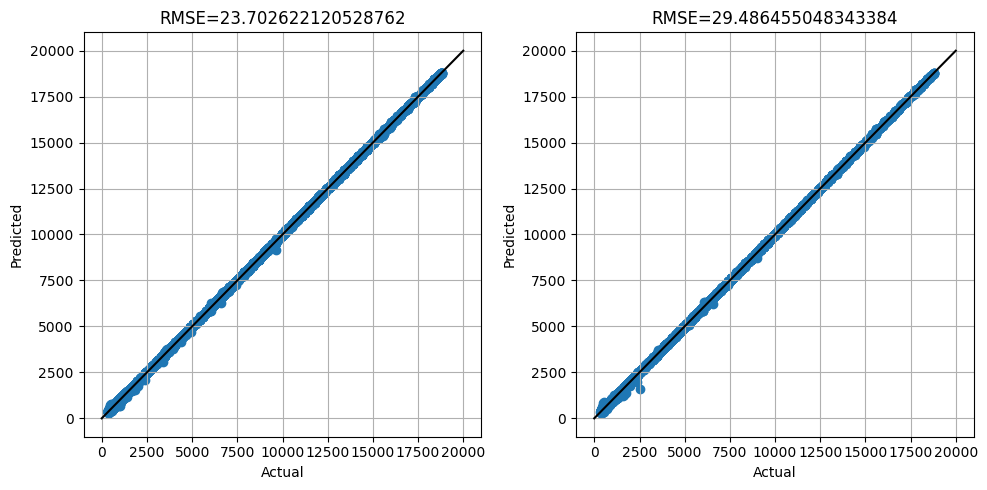

In [3]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror"}
n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n
)

y_pred_train = model.predict(dtrain_reg)
y_pred_test = model.predict(dtest_reg)
rmse_train = math.sqrt(mean_squared_error(y_pred_train, y_train))
rmse_test = math.sqrt(mean_squared_error(y_pred_test, y_test))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,
                               tight_layout=True,
                               figsize=(10,5))
ax1.scatter(y_train,y_pred_train)
ax1.plot(np.array([-10, 20000]),np.array([-10, 20000]),color='k')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title(f"RMSE={rmse_train}")
ax1.grid()
ax2.scatter(y_test,y_pred_test)
ax2.plot(np.array([-10, 20000]),np.array([-10, 20000]),color='k')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.set_title(f"RMSE={rmse_test}")
ax2.grid()
plt.show()

## Predicting Diamond Cut via XGBoost Classification
Different problem: Predict whether a diamond cut is ideal, premium, or good.

In [4]:
# Separate data into X (inputs) and y (target)
X, y = diamonds.drop("cut", axis=1), diamonds[['cut']]

# Encode y to numeric
y_encoded = OrdinalEncoder().fit_transform(y)

# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to pd.Categorical
for col in cats:
   X[col] = X[col].astype('category')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=1, stratify=y_encoded)

Setup and train xgboost

In [5]:
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

params = {"objective": "multi:softprob", "num_class": 5}
n = 1000

# XGBoost with cross-validation is used
results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=5,
   metrics=["mlogloss", "auc", "merror"]
)

In [6]:
print(results)

     train-mlogloss-mean  train-mlogloss-std  train-auc-mean  train-auc-std  \
0               1.257263            0.000701        0.892007   4.053408e-04   
1               1.073006            0.000795        0.896998   3.591949e-04   
2               0.955165            0.001119        0.900089   7.123014e-04   
3               0.873976            0.001432        0.902935   9.467494e-04   
4               0.815711            0.001760        0.905321   9.788936e-04   
..                   ...                 ...             ...            ...   
995             0.044178            0.001238        1.000000   4.590364e-07   
996             0.044099            0.001222        1.000000   4.572847e-07   
997             0.044018            0.001215        1.000000   4.460140e-07   
998             0.043941            0.001226        1.000000   4.472754e-07   
999             0.043896            0.001233        1.000000   4.474730e-07   

     train-merror-mean  train-merror-std  test-mlog

In [7]:
print(f"Maximum Mean-AUC on Test Data: {results['test-auc-mean'].max()}")

Maximum Mean-AUC on Test Data: 0.9407518046874198
